In [1]:
%%html
<style>
    table {float:left}
</style>

In [2]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import Preprocessing as pp
import scipy
from sklearn import metrics
import warnings
warnings.filterwarnings(action = 'once')

In [3]:
OPEN_FOLDER = '../Data/Temp_Data/'

In [4]:
kit_orange = pp.getColor('orange')
kit_green = pp.getColor('green')
kit_blue = pp.getColor('blue')
kit_cyan = pp.getColor('cyan')
kit_red = pp.getColor('red')
kit_lightgreen = pp.getColor('lightgreen')
kit_grey = pp.getColor('grey')

## Specify Methods needed for approximation

In [5]:
def findBounds(dataTime, dataValue, time_splits):
    fig,axs = plt.subplots(math.ceil((len(time_splits))/2), 2, figsize = (20,12))
    axs = axs.ravel()
    axs[0].plot(dataTime, dataValue)
    
    for t in range(len(time_splits) -1):
        cut_point_prior = math.ceil(time_splits[t])
        cut_point_post = math.ceil(time_splits[t+1])
        axs[t+1].plot(dataTime[cut_point_prior:cut_point_post], dataValue[cut_point_prior:cut_point_post])

In [6]:
def exp_func(x, k, tau):
    return -k* np.exp((-1/tau)*x) +k

In [7]:
def quadr_func(x, p1, p2, p3):
    return p1 * x**2 + p2*x + p3

In [8]:
def linear_func(x, a,b):
    return a*x + b

In [9]:
def approx(time, values):
    assert len(time) == len(values), 'time and values should have the same length'
    segment_start_value = values[0]
    
    param_bounds = ([-np.inf, -np.inf], [np.inf, np.inf])
    para_fit, pcov = scipy.optimize.curve_fit(exp_func, time - time[0], values- segment_start_value, bounds=param_bounds)
    k_best = para_fit[0]
    tau_best = para_fit[1]    
    return k_best, tau_best

In [10]:
def allApproximation(dataTime, dataInput, dataValue, time_splits):
    fig,axs = plt.subplots(math.ceil(len(time_splits)/2), 2, figsize = (20,12))
    axs = axs.ravel()
    approximations = np.full(shape = len(dataTime), fill_value= np.nan)
    parameters = []
    
    for t in range(len(time_splits) -1):
        cut_point_prior = math.ceil(time_splits[t])
        cut_point_post = math.ceil(time_splits[t+1])
        time_segment = np.array(dataTime[cut_point_prior:cut_point_post])
        value_segment = np.array(dataValue[cut_point_prior:cut_point_post])
        input_start = dataInput[cut_point_prior]
        input_end = dataInput[cut_point_post -1]
       
        k_best, tau_best = approx(time_segment,
                                  value_segment)
        segment_approximation = exp_func(time_segment-time_segment[0], k_best, tau_best) + value_segment[0]
        approximations[cut_point_prior:cut_point_post] = segment_approximation
        prs = [input_start, input_end, k_best, tau_best]
        parameters = np.concatenate((parameters, prs), axis = 0)
        
        axs[t].plot(time_segment, value_segment)
        axs[t].plot(time_segment, segment_approximation)
        
        
    
    axs[-1].plot(dataTime, dataValue)
    axs[-1].plot(dataTime, approximations)
    return approximations, parameters.reshape(len(time_splits) -1, 4)

In [11]:
def getTimeSplits(df):
    time_splits = [x for x in range(len(df)-1) if df.iloc[x]['input_voltage'] != df.iloc[x+1]['input_voltage']]
    time_splits.append(len(df))
    if time_splits[0] != 0:
        time_splits.insert(0,0)
    return time_splits

This is the only cell that needs adaptation depending on the experiment!

In [12]:
exp_4 = pp.openCSVFile('experiment_4b_short.csv', OPEN_FOLDER)

In [13]:
time_splits_4 = getTimeSplits(exp_4)
time_splits_4

[0, 1073, 2297, 3513, 4733, 5953, 7168, 8386, 9601, 10540]

## Execute Approximations for Transitions

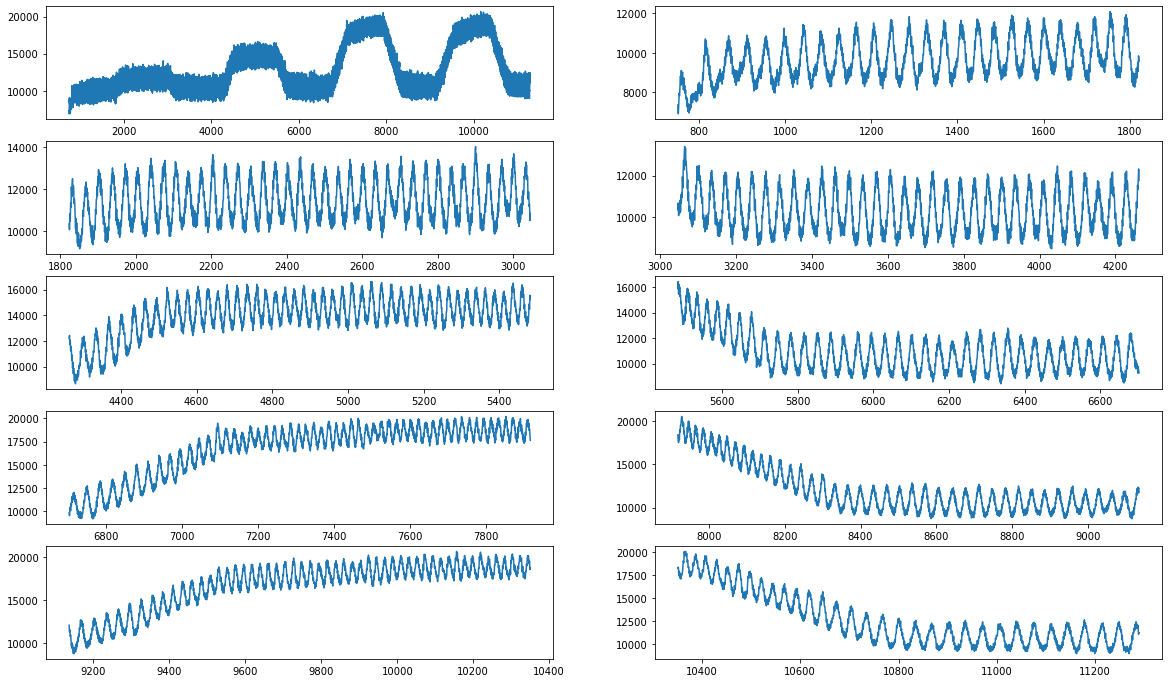

In [14]:
findBounds(exp_4['time'], exp_4['th_power'], time_splits_4)

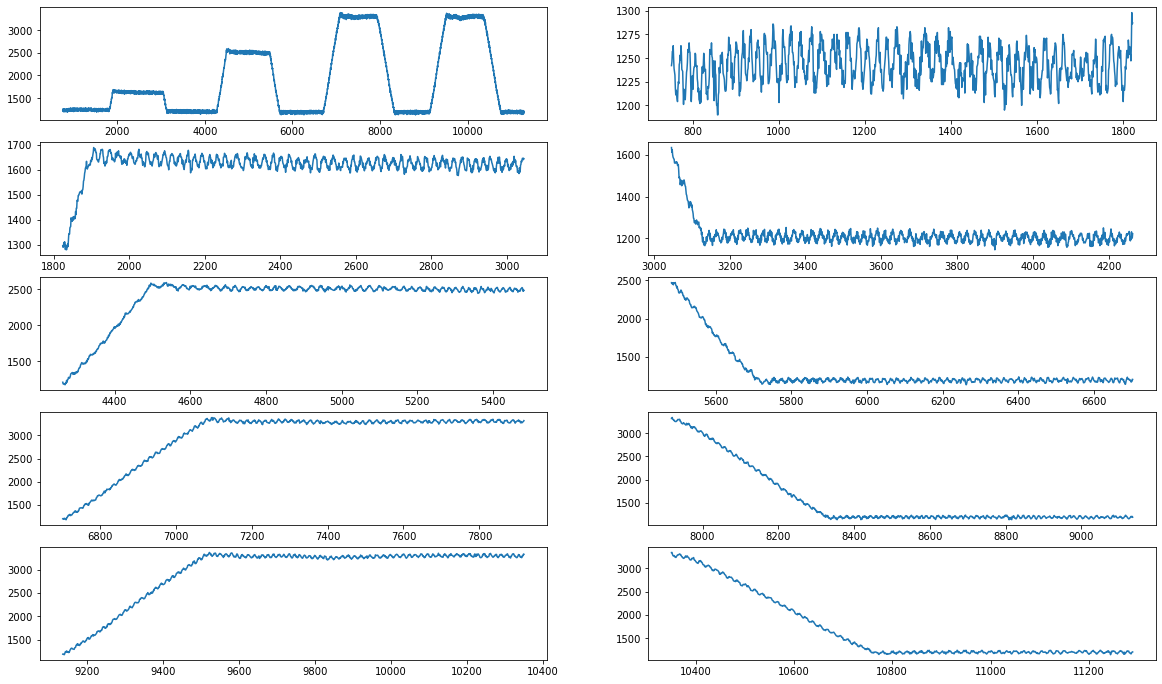

In [15]:
findBounds(exp_4['time'], exp_4['el_power'], time_splits_4)

<ipython-input-6-4e89d8264459>:2: RuntimeWarning: overflow encountered in exp
  return -k* np.exp((-1/tau)*x) +k


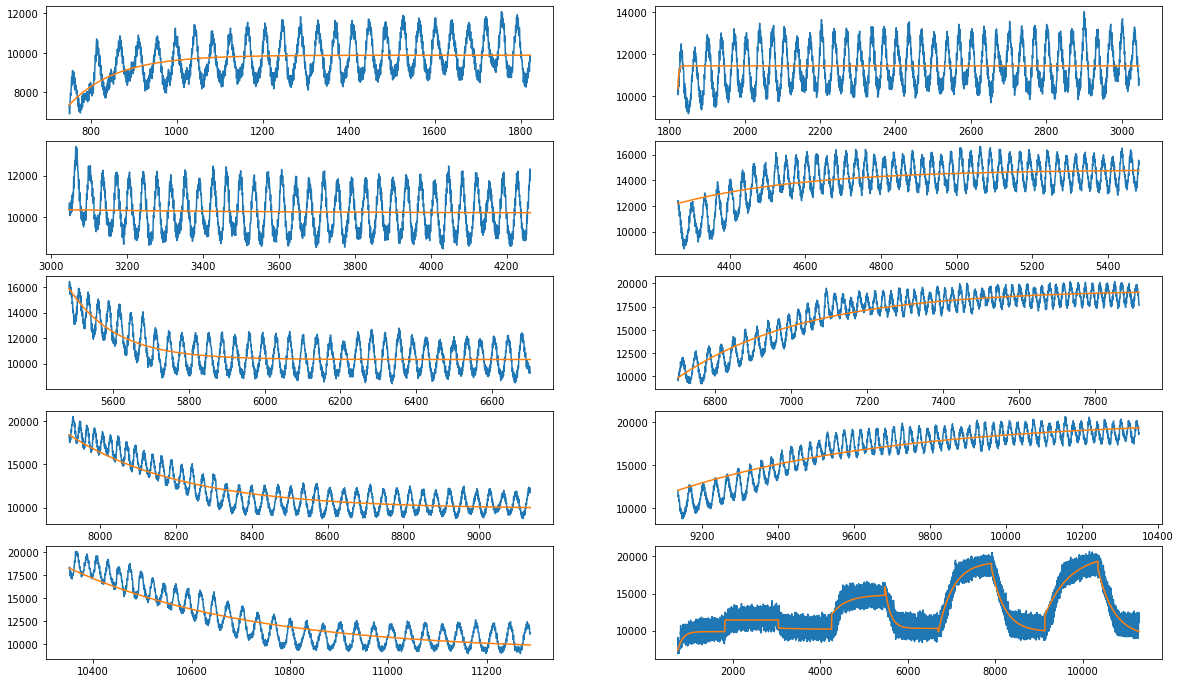

In [16]:
exp_4['th_approx'], params_exp4_th = allApproximation(exp_4['time'], exp_4['input_voltage'], exp_4['th_power'], time_splits_4)

<ipython-input-6-4e89d8264459>:2: RuntimeWarning: overflow encountered in exp
  return -k* np.exp((-1/tau)*x) +k


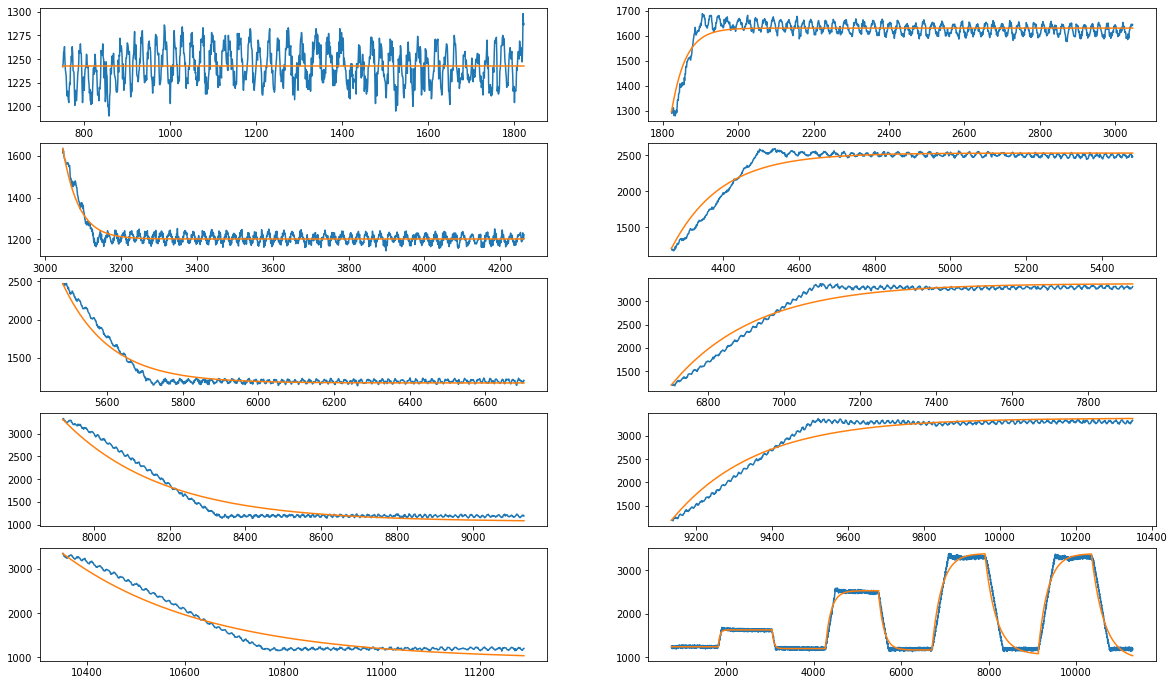

In [17]:
exp_4['el_approx'], params_exp4_el = allApproximation(exp_4['time'], exp_4['input_voltage'], exp_4['el_power'], time_splits_4)

<ipython-input-6-4e89d8264459>:2: RuntimeWarning: overflow encountered in exp
  return -k* np.exp((-1/tau)*x) +k
<ipython-input-6-4e89d8264459>:2: RuntimeWarning: overflow encountered in multiply
  return -k* np.exp((-1/tau)*x) +k


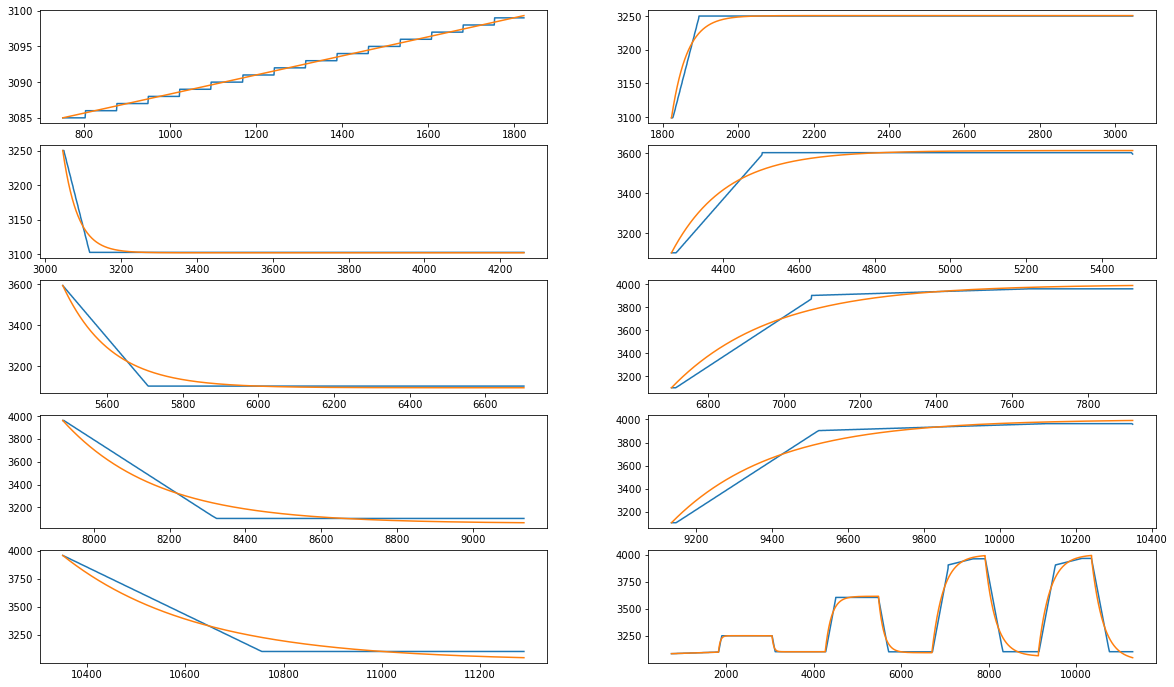

In [18]:
exp_4['spin_fit'], params_exp4_spin = allApproximation(exp_4['time'], exp_4['input_voltage'], exp_4['spinning_approx'], time_splits_4)

## Stationary parameters

In [19]:
fit_voltage = [3,5,7.5, 10]
fit_spin = [3103, 3250, 3604, 3961]
fit_el = [1200, 1637, 2509, 3300]
fit_th = [10480, 11700, 14700, 18690]

In [20]:
prm_fit_st_th, pcov_th = scipy.optimize.curve_fit(quadr_func, fit_voltage, fit_th)
prm_fit_st_el, pcov_el = scipy.optimize.curve_fit(quadr_func, fit_voltage, fit_el)
prm_fit_st_spin, pcov_spin = scipy.optimize.curve_fit(quadr_func, fit_voltage, fit_spin)

In [21]:
p1, p2, p3 = prm_fit_st_th
exp_4['th_pred'] = quadr_func(exp_4['input_voltage'], p1, p2, p3)

In [22]:
p1, p2, p3 = prm_fit_st_el
exp_4['el_pred'] = quadr_func(exp_4['input_voltage'], p1, p2, p3)

In [23]:
p1, p2, p3 = prm_fit_st_spin
exp_4['spin_pred'] = quadr_func(exp_4['input_voltage'], p1, p2, p3)

## Comparison of fits 

Comparison of the approaches and fits compared to true values:

Variable|Approach|RMSE|R^2|MAE|MaxAE
---|----|----:|----:|---:|---:
**Spinning**|**exponential**|**37.264**|**0.987**|**23.183**|**129.704**
Spinning|stationary|210.845|0.570|98.725|868.402
**Electric**|**exponential**|**109.274**|**0.982**|**72.463**|**375.395**
Electric|stationary| 518.049|0.589|239.259|2166.749
**Thermal**|**exponential**|**1105.615**|**0.882**|**925.458**|**3662.547**
Thermal|stationary|2444.558|0.423|1618.027|10083.339

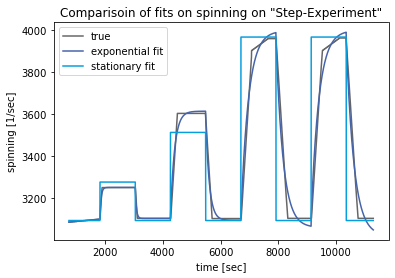

In [24]:
plt.plot(exp_4['time'], exp_4['spinning_approx'], color = kit_grey, label = 'true')
plt.plot(exp_4['time'], exp_4['spin_fit'], color = kit_blue, label = 'exponential fit')
plt.plot(exp_4['time'], exp_4['spin_pred'], color = kit_cyan, label = 'stationary fit')
plt.title('Comparisoin of fits on spinning on "Step-Experiment"')
plt.xlabel('time [sec]')
plt.ylabel('spinning [1/sec]')
plt.legend()

In [25]:
pp.measureDifference(exp_4, 'spinning_approx', 'spin_fit') # exponential

The RMSE is 37.264
The R2-score is 0.987
The MAE is 23.183
The MaxAE is 129.704


In [26]:
pp.measureDifference(exp_4, 'spinning_approx', 'spin_pred') # stationary

The RMSE is 210.845
The R2-score is 0.570
The MAE is 98.725
The MaxAE is 868.402


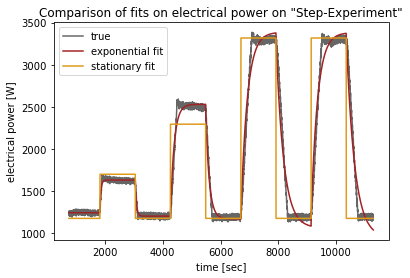

In [27]:
plt.plot(exp_4['time'], exp_4['el_power'], color = kit_grey, label = 'true')
plt.plot(exp_4['time'], exp_4['el_approx'], color = kit_red, label = 'exponential fit')
plt.plot(exp_4['time'], exp_4['el_pred'], color = kit_orange, label = 'stationary fit')
plt.title('Comparison of fits on electrical power on "Step-Experiment"')
plt.xlabel('time [sec]')
plt.ylabel('electrical power [W]')
plt.legend()

In [28]:
pp.measureDifference(exp_4, 'el_power', 'el_approx') # exponential

The RMSE is 109.274
The R2-score is 0.982
The MAE is 72.463
The MaxAE is 375.395


In [29]:
pp.measureDifference(exp_4, 'el_power', 'el_pred') # stationary

The RMSE is 518.049
The R2-score is 0.589
The MAE is 239.259
The MaxAE is 2166.749


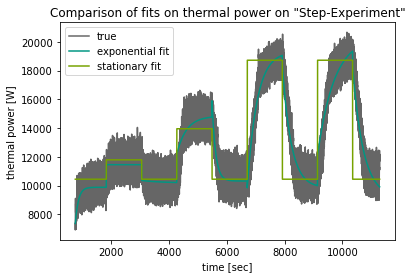

In [30]:
plt.plot(exp_4['time'], exp_4['th_power'], color = kit_grey, label = 'true')
plt.plot(exp_4['time'], exp_4['th_approx'], color = kit_green, label = 'exponential fit')
plt.plot(exp_4['time'], exp_4['th_pred'], color = kit_lightgreen, label = 'stationary fit')
plt.title('Comparison of fits on thermal power on "Step-Experiment"')
plt.xlabel('time [sec]')
plt.ylabel('thermal power [W]')
plt.legend()

In [31]:
pp.measureDifference(exp_4, 'th_power', 'th_approx') # exponential

The RMSE is 1105.615
The R2-score is 0.882
The MAE is 925.458
The MaxAE is 3662.547


In [32]:
pp.measureDifference(exp_4, 'th_power', 'th_pred') # stationary

The RMSE is 2444.558
The R2-score is 0.423
The MAE is 1618.027
The MaxAE is 10083.339


## Evaluation on different experiment 

In [33]:
def lookAtFittingParameters(params):
    df_params = pd.DataFrame(params)
    df_params.columns = ['input_start', 'input_end', 'k_best', 'tau_best']
    df_params['Input_diff'] = [df_params.iloc[x]['input_end'] - df_params.iloc[x]['input_start'] for x in range(len(df_params))]
    
    fig,axs = plt.subplots(1, 2, figsize = (10,5))
    axs = axs.ravel()
    axs[1].scatter(df_params['Input_diff'], df_params['tau_best'], label = 'tau')
    axs[1].set_title('Tau over input difference')
    axs[1].set_ylabel('tau')
    axs[1].set_xlabel('input difference')
    axs[0].scatter(df_params['Input_diff'], df_params['k_best'], label ='k')
    axs[0].set_title('k over input difference')
    axs[0].set_ylabel('k')
    axs[0].set_xlabel('input difference')
    
    return df_params

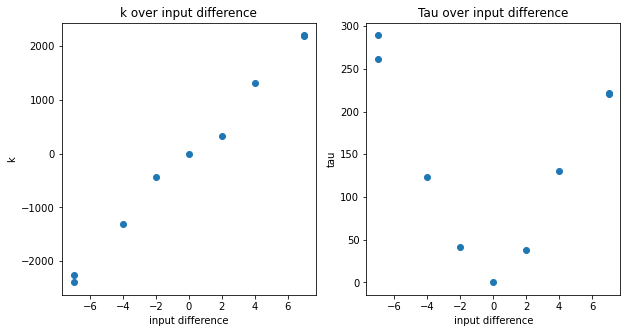

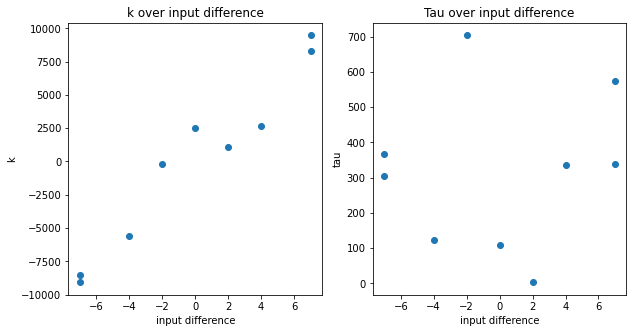

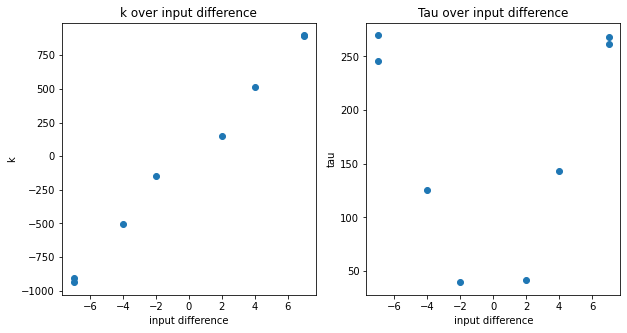

In [34]:
df_el4_prms = lookAtFittingParameters(params_exp4_el)
df_th4_prms = lookAtFittingParameters(params_exp4_th)
df_spin4_prms = lookAtFittingParameters(params_exp4_spin[1:]) # the first instances where the difference is 0 is a large outlier in this case

In [35]:
def metaParameterModelling(df, func_k, func_tau):
    prm_fit_k, pcov_k = scipy.optimize.curve_fit(func_k, df['Input_diff'], df['k_best'])
    prm_fit_tau, pcov_tau = scipy.optimize.curve_fit(func_tau, df['Input_diff'], df['tau_best'])
    
    return prm_fit_k, prm_fit_tau

In [36]:
k_el, tau_el = metaParameterModelling(df_el4_prms, linear_func, quadr_func)
k_th, tau_th = metaParameterModelling(df_th4_prms, linear_func, quadr_func)
k_spin, tau_spin = metaParameterModelling(df_spin4_prms, linear_func, quadr_func)

Our expert stated, that there are quadratic relationships between the outputs and the input so they might reflect on the parameters. The scatter plots suggest a quadratic relationship of tau to the difference and a linear relationship of k to the input difference.

## Prediction with fitted parameters 

In [37]:
exp_1 = pp.openCSVFile('experiment_1_short.csv', OPEN_FOLDER)
exp_9 = pp.openCSVFile('experiment_9_short.csv', OPEN_FOLDER)

In [38]:
def predictOnOtherExperiment(parameters_k, parameters_tau, data, header):
    time_splits = getTimeSplits(data)
    dataTime = data['time']
    dataValue = data[header]
    dataInput = data['input_voltage']
    prm_k = np.empty(3)
    prm_tau = np.empty(3)
    prm_k[0], prm_k[1] = parameters_k
    prm_tau[0], prm_tau[1], prm_tau[2] = parameters_tau
    
#     fig,axs = plt.subplots(math.ceil(len(time_splits)/2), 2, figsize = (20,12))
#     axs = axs.ravel()
    approximations = np.full(shape = len(dataTime), fill_value= np.nan)
    
    for t in range(len(time_splits) -1):
        cut_point_prior = math.ceil(time_splits[t])
        cut_point_post = math.ceil(time_splits[t+1])
        time_segment = np.array(dataTime[cut_point_prior:cut_point_post])
        value_segment = np.array(dataValue[cut_point_prior:cut_point_post])
        input_start = dataInput[cut_point_prior]
        input_end = dataInput[cut_point_post -1]
        input_diff = input_end - input_start
        
        k = linear_func(input_diff, prm_k[0], prm_k[1])
        tau = quadr_func(input_diff, prm_tau[0], prm_tau[1], prm_tau[2])
        
        segment_approximation = exp_func(time_segment-time_segment[0], k, tau) + value_segment[0]
        approximations[cut_point_prior:cut_point_post] = segment_approximation
        
#         axs[t].plot(time_segment, value_segment)
#         axs[t].plot(time_segment, segment_approximation)
        
        
    
#     plt.plot(dataTime, dataValue)
#     plt.plot(dataTime, approximations)
    return approximations

### On Experiment 1 

In [39]:
exp_1['el_pred'] = predictOnOtherExperiment(k_el, tau_el, exp_1, 'el_power')
exp_1['th_pred'] = predictOnOtherExperiment(k_th, tau_th, exp_1, 'th_power')
exp_1['spin_pred'] = predictOnOtherExperiment(k_spin, tau_spin, exp_1, 'spinning_ist')

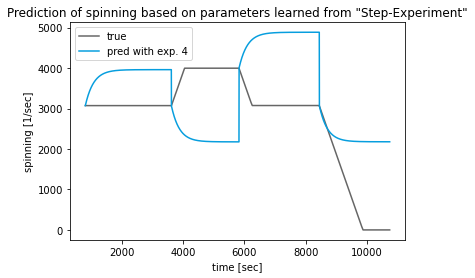

In [40]:
plt.plot(exp_1['time'], exp_1['spinning_ist'], color = kit_grey, label = 'true')
plt.plot(exp_1['time'], exp_1['spin_pred'], color = kit_cyan, label = 'pred with exp. 4')
plt.title('Prediction of spinning based on parameters learned from "Step-Experiment"')
plt.xlabel('time [sec]')
plt.ylabel('spinning [1/sec]')
plt.legend()

In [41]:
pp.measureDifference(exp_1, 'spinning_ist', 'spin_pred')

The RMSE is 1466.611
The R2-score is -0.559
The MAE is 1331.819
The MaxAE is 2182.339


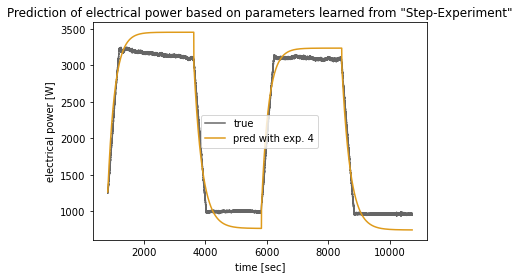

In [42]:
plt.plot(exp_1['time'], exp_1['el_power'], color = kit_grey, label = 'true')
plt.plot(exp_1['time'], exp_1['el_pred'], color = kit_orange, label = 'pred with exp. 4')
plt.title('Prediction of electrical power based on parameters learned from "Step-Experiment"')
plt.xlabel('time [sec]')
plt.ylabel('electrical power [W]')
plt.legend()

In [43]:
pp.measureDifference(exp_1, 'el_power', 'el_pred')

The RMSE is 203.399
The R2-score is 0.959
The MAE is 183.940
The MaxAE is 412.711


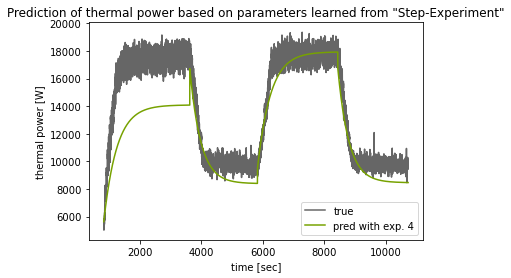

In [44]:
plt.plot(exp_1['time'], exp_1['th_power'], color = kit_grey, label = 'true')
plt.plot(exp_1['time'], exp_1['th_pred'], color = kit_lightgreen, label = 'pred with exp. 4')
plt.title('Prediction of thermal power based on parameters learned from "Step-Experiment"')
plt.xlabel('time [sec]')
plt.ylabel('thermal power [W]')
plt.legend()

In [45]:
pp.measureDifference(exp_1, 'th_power', 'th_pred')

The RMSE is 2190.748
The R2-score is 0.647
The MAE is 1659.354
The MaxAE is 6352.712


### On Experiment 9 

In [46]:
exp_9['el_pred'] = predictOnOtherExperiment(k_el, tau_el, exp_9, 'el_power')
exp_9['th_pred'] = predictOnOtherExperiment(k_th, tau_th, exp_9, 'th_power')
exp_9['spin_pred'] = predictOnOtherExperiment(k_spin, tau_spin, exp_9, 'spinning_approx')

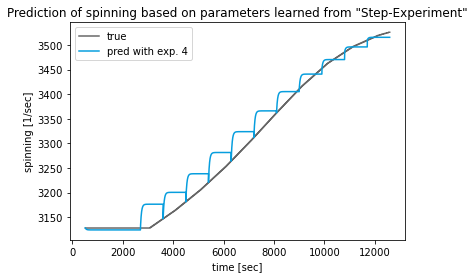

In [47]:
plt.plot(exp_9['time'], exp_9['spinning_approx'], color = kit_grey, label = 'true')
plt.plot(exp_9['time'], exp_9['spin_pred'], color = kit_cyan, label = 'pred with exp. 4')
plt.title('Prediction of spinning based on parameters learned from "Step-Experiment"')
plt.xlabel('time [sec]')
plt.ylabel('spinning [1/sec]')
plt.legend()

In [48]:
pp.measureDifference(exp_9, 'spinning_approx', 'spin_pred')

The RMSE is 25.575
The R2-score is 0.968
The MAE is 19.636
The MaxAE is 53.053


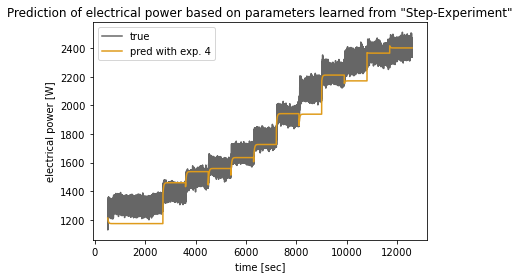

In [49]:
plt.plot(exp_9['time'], exp_9['el_power'], color = kit_grey, label = 'true')
plt.plot(exp_9['time'], exp_9['el_pred'], color = kit_orange, label = 'pred with exp. 4')
plt.title('Prediction of electrical power based on parameters learned from "Step-Experiment"')
plt.xlabel('time [sec]')
plt.ylabel('electrical power [W]')
plt.legend()

In [50]:
pp.measureDifference(exp_9, 'el_power', 'el_pred')

The RMSE is 101.242
The R2-score is 0.937
The MAE is 82.371
The MaxAE is 285.754


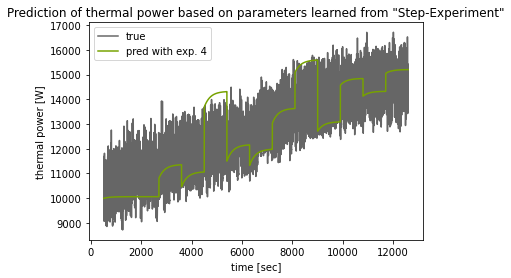

In [51]:
plt.plot(exp_9['time'], exp_9['th_power'], color = kit_grey, label = 'true')
plt.plot(exp_9['time'], exp_9['th_pred'], color = kit_lightgreen, label = 'pred with exp. 4')
plt.title('Prediction of thermal power based on parameters learned from "Step-Experiment"')
plt.xlabel('time [sec]')
plt.ylabel('thermal power [W]')
plt.legend()

In [52]:
pp.measureDifference(exp_9, 'th_power', 'th_pred')

The RMSE is 1394.072
The R2-score is 0.321
The MAE is 1111.376
The MaxAE is 3963.333


Comparison of predictions using the fits of experiment 4 to true values:

Experiment 1:

Variable|RMSE|R^2|MAX|MaxAE
---|----:|----:|---:|----:
 Spinning  | 1466.611 | -0.559 | 1331.819 | 2182.339
 Electric  | 203.399 | 0.959 | 183.940 | 412.711
 Thermal  | 2190.748 | 0.647 | 1659.354 | 6352.712 

Experiment 9:

Variable|RMSE|R^2|MAE|MaxAE
---|----:|----:|---:|---:
 Spinning  | 25.575 | 0.968 | 19.636 | 53.053 
 Electric  | 101.242 | 0.937 | 82.971 | 285.754 
 Thermal  | 1394.072 | 0.321 | 1111.376 | 3963.333